# Bayesian Mixture Model

A Bayesian mixture model assumes that parameters come from a weighted combination of different distributions rather than a single distribution, allowing the model to automatically identify and handle heterogeneity in parameter types while providing uncertainty quantification about which component each parameter belongs to.

# Graphical Summary

![fig](./graphical_summary/Slide27.png)

# Key Formula

In a mixture model, we assume that the variable $\beta$ is generated from a weighted sum of $K$ different distributions, where each distribution corresponds to a different "component" representing different types of genetic effects. The probability density function (PDF) of the mixture prior can be written as:

$$
p(\beta) = \sum_{k=1}^{K} \pi_k p_k(\beta)
$$

Where:

- $p(\beta)$ is the overall prior probability density function for the genetic effect $\beta$
- $K$ is the number of component distributions
- $\pi_k$ is the mixture weight for the $k$-th component (with $\sum_{k=1}^{K} \pi_k = 1$)
- $p_k(\beta)$ is the probability density function of the $k$-th component, typically $p_k(\beta) = \mathcal{N}(\mu_k, \sigma_k^2)$


![fig](./graphical_summary/Slide27.png)

# Technical Details

## Component Assignment

We don't know which component that the parameter $\beta$ belongs to, and it could come from several different distributions. We introduce a latent variable $z$ to indicate component membership:

$$
z \in \{1, 2, \ldots, K\}
$$
$$
P(z = k) = \pi_k
$$

Given the component assignment, the parameter follows:
$$
\beta \mid z = k \sim p_k(\beta)
$$

where $p_k(\beta)$ is the probability density function for component $k$.

## Prior Specifications

**Mixture Weights:**
$$
\boldsymbol{\pi} = (\pi_1, \pi_2, \ldots, \pi_K) \sim \text{Dirichlet}(\alpha_1, \alpha_2, \ldots, \alpha_K)
$$

**Component Parameters:**
Each component $k$ has its own parameters $\theta_k$ with appropriate priors depending on the chosen distribution family.

## Posterior Inference

**Component Assignment Probability:**
After observing data, the probability that $\beta$ belongs to component $k$ is:

$$
P(z = k \mid \beta, \text{data}) = \frac{\pi_k p_k(\beta)}{\sum_{j=1}^K \pi_j p_j(\beta)}
$$

This tells us how confident we are about which component the parameter belongs to.

## Why Use Mixture Models?

1. **Flexibility**: Can model complex, multi-modal distributions
2. **Automatic clustering**: Parameters naturally group into similar types
3. **Robustness**: Less sensitive to outliers than single component models
4. **Uncertainty quantification**: Provides probabilities for component membership

# Example

This example demonstrates how Bayesian mixture models can be used to detect pleiotropy by comparing different hypotheses about how a genetic variant affects multiple traits. The model automatically identifies whether the data is better explained by scenarios where the variant affects traits independently (no pleiotropy) or with correlated effects (pleiotropy).

In [180]:
rm(list=ls())
library(MASS)
library(ggplot2)
library(dplyr)
library(gridExtra)
library(mvtnorm)
set.seed(101)

## Model Setup

We have:
- $Y_{N \times 2}$: phenotype matrix (height and weight for N individuals)  
- $X_{N \times 1}$: genotype vector (0, 1, 2 coding for one variant)
- $\beta_{1 \times 2}$: effect vector for the variant on both traits

The model is: $Y = X\beta + \varepsilon$


We define 7 different component models representing different patterns of genetic effects:

### Individual Models:
- **M0 (Null)**: No effect on either trait
- **M1**: Effect only on height  
- **M2**: Effect only on weight
- **M3**: Perfect correlation between height and weight effects
- **M4**: Weak correlation (0.1)
- **M5**: Medium correlation (0.5) 
- **M6**: Strong correlation (0.8)

### Mixture Models:
- **No Pleiotropy**: Mixture of M0, M1, M2 (equal weights)
- **Pleiotropy**: Mixture of M3, M4, M5, M6 (equal weights)


In [181]:
models <- list(
  M0 = matrix(c(0, 0, 0, 0), 2, 2),           # Null
  M1 = matrix(c(1, 0, 0, 0), 2, 2),           # Height only
  M2 = matrix(c(0, 0, 0, 1), 2, 2),           # Weight only  
  M3 = matrix(c(1, 1, 1, 1), 2, 2),           # Perfect correlation
  M4 = matrix(c(1, 0.8, 0.8, 1), 2, 2),       # Strong correlation
  M5 = matrix(c(1, 0.5, 0.5, 1), 2, 2),       # Medium correlation
  M6 = matrix(c(1, 0.1, 0.1, 1), 2, 2)        # Weak correlation
)

In [182]:
# Define mixture models
no_pleiotropy_components <- c("M0", "M1", "M2")
pleiotropy_components <- c("M3", "M4", "M5", "M6")

# Mixture weights
no_pleiotropy_weights <- c(0.5, 0.25, 0.25)  
pleiotropy_weights <- rep(1/4, 4)

cat("No Pleiotropy Mixture:\n")
cat("Components:", no_pleiotropy_components, "\n")
cat("Weights:", no_pleiotropy_weights, "\n\n")

cat("Pleiotropy Mixture:\n") 
cat("Components:", pleiotropy_components, "\n")
cat("Weights:", pleiotropy_weights, "\n")

No Pleiotropy Mixture:
Components: M0 M1 M2 
Weights: 0.5 0.25 0.25 

Pleiotropy Mixture:
Components: M3 M4 M5 M6 
Weights: 0.25 0.25 0.25 0.25 


## Data Generation

In [183]:
# Parameters
n_individuals <- 20
true_mixture <- "pleiotropy"  # Choose which mixture generates the data
effect_scale <- 2  # Scale factor for effect sizes

# Generate genotypes (0, 1, 2 with MAF = 0.3)
maf <- 0.3
p_genotypes <- c((1-maf)^2, 2*maf*(1-maf), maf^2)
genotypes <- sample(0:2, n_individuals, replace = TRUE, prob = p_genotypes)

# Function to sample from a mixture model
sample_from_mixture <- function(components, weights, scale = 1) {
  # Sample component
  component_idx <- sample(1:length(components), 1, prob = weights)
  chosen_component <- components[component_idx]
  
  # Sample beta from the chosen component
  cov_matrix <- models[[chosen_component]] * scale^2
  
  # Handle the null case (M0)
  if (all(cov_matrix == 0)) {
    beta <- c(0, 0)
  } else {
    # Add small diagonal to ensure positive definite
    cov_matrix <- cov_matrix + diag(0.01, 2)
    beta <- mvrnorm(1, mu = c(0, 0), Sigma = cov_matrix)
  }
  
  return(list(beta = beta, component = chosen_component))
}

# Generate true effect from the mixture
if (true_mixture == "no_pleiotropy") {
  result <- sample_from_mixture(no_pleiotropy_components, no_pleiotropy_weights, effect_scale)
} else {
  result <- sample_from_mixture(pleiotropy_components, pleiotropy_weights, effect_scale)
}

true_beta <- result$beta
true_component <- result$component

In [184]:
# Generate phenotypes
baseline_height <- 170  # cm
baseline_weight <- 70   # kg
residual_sd <- c(8, 5)  # residual standard deviations

# Genetic effects
genetic_effects <- outer(genotypes, true_beta)

# Environmental effects
environmental_effects <- cbind(
  rnorm(n_individuals, 0, residual_sd[1]),
  rnorm(n_individuals, 0, residual_sd[2])
)

# Final phenotypes
phenotypes <- matrix(c(baseline_height, baseline_weight), n_individuals, 2, byrow = TRUE) + 
              genetic_effects + environmental_effects

colnames(phenotypes) <- c("height", "weight")

# Create dataset
data <- data.frame(
  id = 1:n_individuals,
  genotype = genotypes,
  height = phenotypes[, 1],
  weight = phenotypes[, 2]
)


## Bayesian Inference

The key idea of the Bayesian mixture model is that we don't know which component the genetic effect comes from. We treat the component assignment as a latent variable and compute posterior probabilities for each component.

In [185]:
# Function to compute log-likelihood for given beta values
log_likelihood <- function(beta, genotypes, phenotypes) {
  n <- nrow(phenotypes)
  ll <- 0
  
  for (i in 1:n) {
    # Predicted phenotype for individual i
    pred <- c(baseline_height, baseline_weight) + genotypes[i] * beta
    
    # Residual covariance matrix (assumed independent)
    residual_cov <- diag(residual_sd^2)
    
    # Add to log-likelihood
    diff <- phenotypes[i, ] - pred
    ll <- ll - 0.5 * t(diff) %*% solve(residual_cov) %*% diff - 
          0.5 * log(det(2 * pi * residual_cov))
  }
  
  return(as.numeric(ll))
}

# Function to compute log-prior for beta given component
log_prior <- function(beta, component_name, scale = effect_scale) {
  cov_matrix <- models[[component_name]] * scale^2
  
  # Handle null case
  if (all(cov_matrix == 0)) {
    return(ifelse(all(abs(beta) < 0.01), 0, -Inf))
  }
  
  # Add small diagonal for numerical stability
  cov_matrix <- cov_matrix + diag(0.01, 2)
  
  # Compute log density
  lp <- -0.5 * t(beta) %*% solve(cov_matrix) %*% beta - 
        0.5 * log(det(2 * pi * cov_matrix))
  
  return(as.numeric(lp))
}

# Function to compute posterior probability for each component
# This integrates over all possible beta values for each component
compute_component_posterior <- function(component_name, genotypes, phenotypes) {
  if (component_name == "M0") {
    # Null model: beta = (0, 0)
    beta <- c(0, 0)
    ll <- log_likelihood(beta, genotypes, phenotypes)
    lp <- log_prior(beta, component_name)
    return(ll + lp)
  }
  
  # For non-null components, we need to integrate over beta
  # We'll use a grid approximation for illustration
  beta_height_range <- seq(-3, 3, length.out = 50)
  beta_weight_range <- seq(-3, 3, length.out = 50)
  grid <- expand.grid(beta_height = beta_height_range, beta_weight = beta_weight_range)
  
  log_marginal <- -Inf
  
  for (i in 1:nrow(grid)) {
    beta <- c(grid$beta_height[i], grid$beta_weight[i])
    
    ll <- log_likelihood(beta, genotypes, phenotypes)
    lp <- log_prior(beta, component_name)
    
    if (is.finite(ll + lp)) {
      log_marginal <- log(exp(log_marginal) + exp(ll + lp))
    }
  }
  
  # Normalize by grid size
  log_marginal <- log_marginal - log(nrow(grid))
  
  return(log_marginal)
}


In [186]:
# Compute posterior probabilities for each component
cat("\nComputing component posterior probabilities...\n")
component_names <- names(models)
log_posteriors <- numeric(length(component_names))

for (i in 1:length(component_names)) {
  comp <- component_names[i]
  log_posteriors[i] <- compute_component_posterior(comp, genotypes, phenotypes)
  cat("Component", comp, ": log posterior =", round(log_posteriors[i], 2), "\n")
}

# Normalize to get probabilities
log_posterior_max <- max(log_posteriors)
posterior_probs <- exp(log_posteriors - log_posterior_max)
posterior_probs <- posterior_probs / sum(posterior_probs)

names(posterior_probs) <- component_names

cat("\nPosterior probabilities for each component:\n")
for (i in 1:length(component_names)) {
  cat(component_names[i], ":", round(posterior_probs[i], 4), "\n")
}


Computing component posterior probabilities...


Component M0 : log posterior = -145.02 
Component M1 : log posterior = -148.77 
Component M2 : log posterior = -144.32 
Component M3 : log posterior = -143.95 
Component M4 : log posterior = -144.18 
Component M5 : log posterior = -144.3 
Component M6 : log posterior = -144.45 

Posterior probabilities for each component:
M0 : 0.0826 
M1 : 0.0019 
M2 : 0.1664 
M3 : 0.2416 
M4 : 0.1916 
M5 : 0.1701 
M6 : 0.1458 


Then we compute posterior probabilities for mixture models

In [187]:
no_pleio_posterior <- sum(posterior_probs[no_pleiotropy_components])
pleio_posterior <- sum(posterior_probs[pleiotropy_components])

cat("\nMixture Model Posterior Probabilities:\n")
cat("P(No Pleiotropy | Data) =", round(no_pleio_posterior, 4), "\n")
cat("P(Pleiotropy | Data) =", round(pleio_posterior, 4), "\n")

# Within-mixture component probabilities
if (pleio_posterior > no_pleio_posterior) {
  cat("\nPleiotropy is more likely. Within pleiotropy mixture:\n")
  pleio_components_probs <- posterior_probs[pleiotropy_components]
  pleio_components_probs <- pleio_components_probs / sum(pleio_components_probs)
  
  for (i in 1:length(pleiotropy_components)) {
    cat(pleiotropy_components[i], ":", round(pleio_components_probs[i], 4), "\n")
  }
} else {
  cat("\nNo pleiotropy is more likely. Within no-pleiotropy mixture:\n")
  no_pleio_components_probs <- posterior_probs[no_pleiotropy_components]
  no_pleio_components_probs <- no_pleio_components_probs / sum(no_pleio_components_probs)
  
  for (i in 1:length(no_pleiotropy_components)) {
    cat(no_pleiotropy_components[i], ":", round(no_pleio_components_probs[i], 4), "\n")
  }
}

# Predictive inference: What effect sizes are most likely?
cat("\nPredictive Summary:\n")
cat("True generating component:", true_component, "\n")
cat("Most probable component:", names(which.max(posterior_probs)), "\n")
cat("True mixture:", true_mixture, "\n")
cat("Most probable mixture:", ifelse(pleio_posterior > no_pleio_posterior, "pleiotropy", "no_pleiotropy"), "\n")



Mixture Model Posterior Probabilities:
P(No Pleiotropy | Data) = 0.251 
P(Pleiotropy | Data) = 0.749 

Pleiotropy is more likely. Within pleiotropy mixture:
M3 : 0.3226 
M4 : 0.2558 
M5 : 0.227 
M6 : 0.1946 

Predictive Summary:
True generating component: M6 
Most probable component: M3 
True mixture: pleiotropy 
Most probable mixture: pleiotropy 


## Visualization

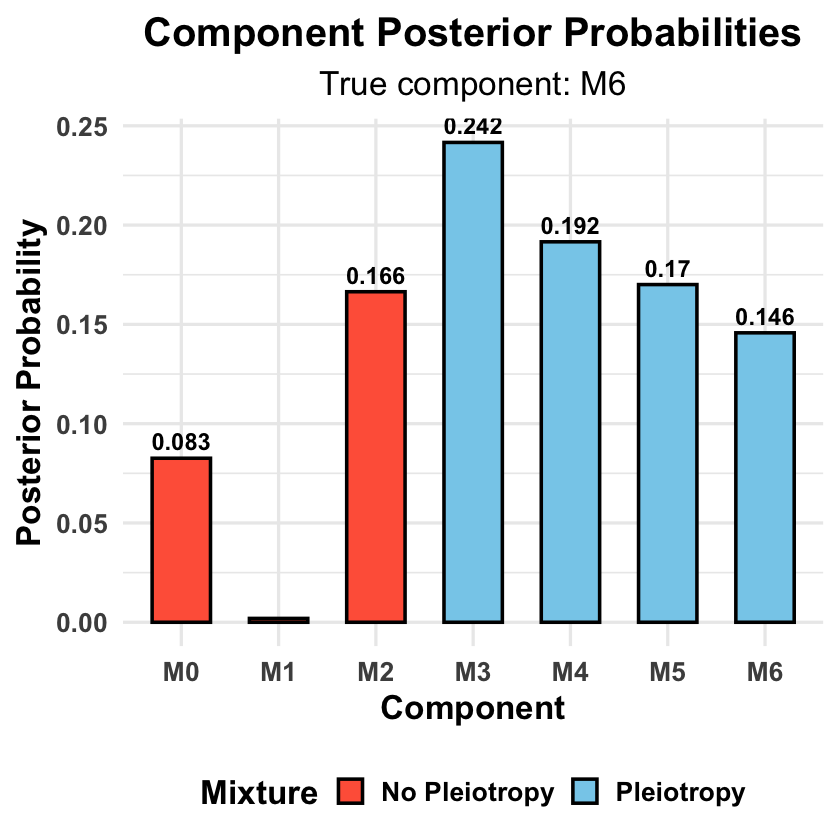

In [188]:
# Create results data frame
results_df <- data.frame(
  Component = component_names,
  Posterior_Probability = posterior_probs,
  Mixture = ifelse(component_names %in% no_pleiotropy_components, 
                   "No Pleiotropy", "Pleiotropy"),
  Is_True = component_names == true_component
)

# Plot component posterior probabilities
p1 <- ggplot(results_df, aes(x = Component, y = Posterior_Probability, fill = Mixture)) +
  geom_col(position = position_dodge(width = 0.8), width = 0.6, color = "black", linewidth = 1) +
  geom_text(aes(label = ifelse(Posterior_Probability > 0.01, 
                              round(Posterior_Probability, 3), "")), 
            position = position_dodge(width = 0.8), vjust = -0.5, size = 5, fontface = "bold") +
  scale_fill_manual(values = c("No Pleiotropy" = "tomato", "Pleiotropy" = "skyblue")) +
  labs(
    title = "Component Posterior Probabilities",
    subtitle = paste("True component:", true_component),
    y = "Posterior Probability",
    x = "Component",
    fill = "Mixture"
  ) +
  theme_minimal(base_size = 20) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5),
    axis.title.y = element_text(face = "bold"),
    axis.title.x = element_text(face = "bold"),
    axis.text.x = element_text(face = "bold"),
    axis.text.y = element_text(face = "bold"),
    legend.title = element_text(face = "bold"),
    legend.text = element_text(face = "bold"),
    legend.position = "bottom"
  )

print(p1)

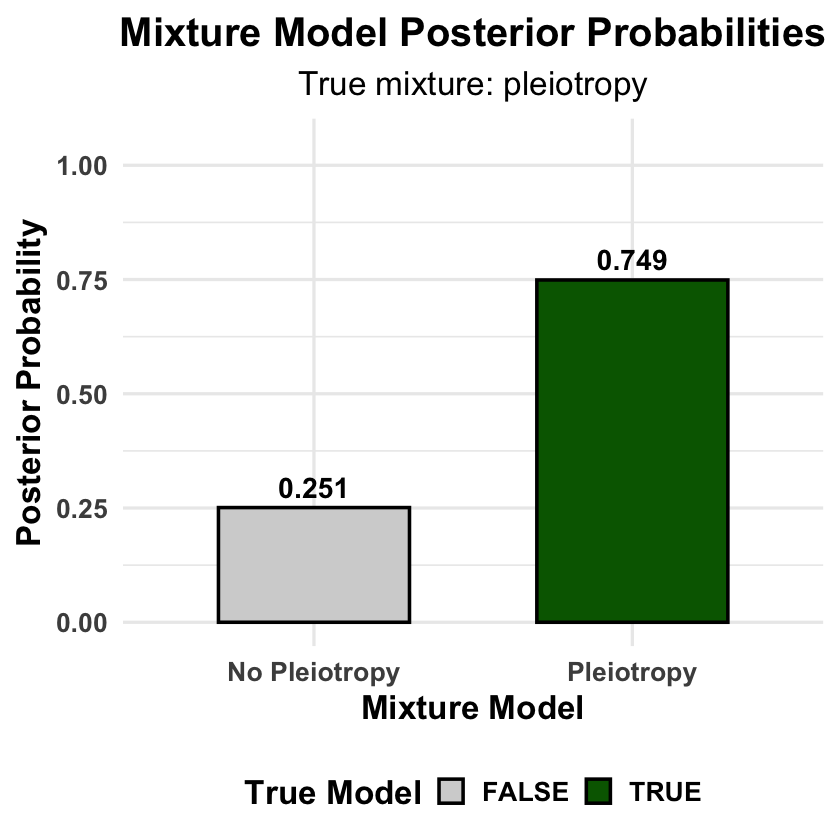

In [189]:
# Plot mixture-level probabilities
mixture_df <- data.frame(
  Mixture = c("No Pleiotropy", "Pleiotropy"),
  Probability = c(no_pleio_posterior, pleio_posterior),
  Is_True = c(true_mixture == "no_pleiotropy", true_mixture == "pleiotropy")
)

p2 <- ggplot(mixture_df, aes(x = Mixture, y = Probability, fill = Is_True)) +
  geom_col(position = position_dodge(width = 0.8), width = 0.6, color = "black", linewidth = 1) +
  geom_text(aes(label = round(Probability, 3)), 
            position = position_dodge(width = 0.8), vjust = -0.5, size = 6, fontface = "bold") +
  scale_fill_manual(values = c("FALSE" = "lightgray", "TRUE" = "darkgreen")) +
  labs(
    title = "Mixture Model Posterior Probabilities",
    subtitle = paste("True mixture:", true_mixture),
    y = "Posterior Probability",
    x = "Mixture Model",
    fill = "True Model"
  ) +
  ylim(0, 1.05) +
  theme_minimal(base_size = 20) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5),
    axis.title.y = element_text(face = "bold"),
    axis.title.x = element_text(face = "bold"),
    axis.text.x = element_text(face = "bold"),
    axis.text.y = element_text(face = "bold"),
    legend.title = element_text(face = "bold"),
    legend.text = element_text(face = "bold"),
    legend.position = "bottom"
  )

print(p2)

## (optional) Connection to Meta-Analysis Random Effects

The Bayesian mixture model for pleiotropy detection extends concepts from random effects meta-analysis in an important way:

**Random Effects Meta-Analysis** assumes all study effects come from a single normal distribution:
$$\beta_i \sim \mathcal{N}(\beta, \tau^2)$$

This models **quantitative heterogeneity** - all studies estimate the same underlying effect, but with continuous variation due to different populations, methods, or sampling error.

**Mixture Models for Pleiotropy** allow effects to come from multiple distinct distributions:
$$\beta \sim \sum_{k=1}^K \pi_k \mathcal{N}(\mu_k, \Sigma_k)$$

This models **qualitative heterogeneity** - genetic variants may have fundamentally different biological mechanisms rather than just varying continuously around a single effect pattern.

In our pleiotropy context:
- **Random effects approach** would assume all variants have some degree of correlated effects across traits, with continuous variation in the correlation strength
- **Mixture model approach** recognizes that some variants may be truly trait-specific (no pleiotropy) while others exhibit different discrete patterns of pleiotropic effects

The mixture model thus provides a more biologically realistic framework by allowing variants to belong to distinct mechanistic categories rather than forcing all genetic effects into a single continuous distribution.

# Supplementary

## Graphical Summary

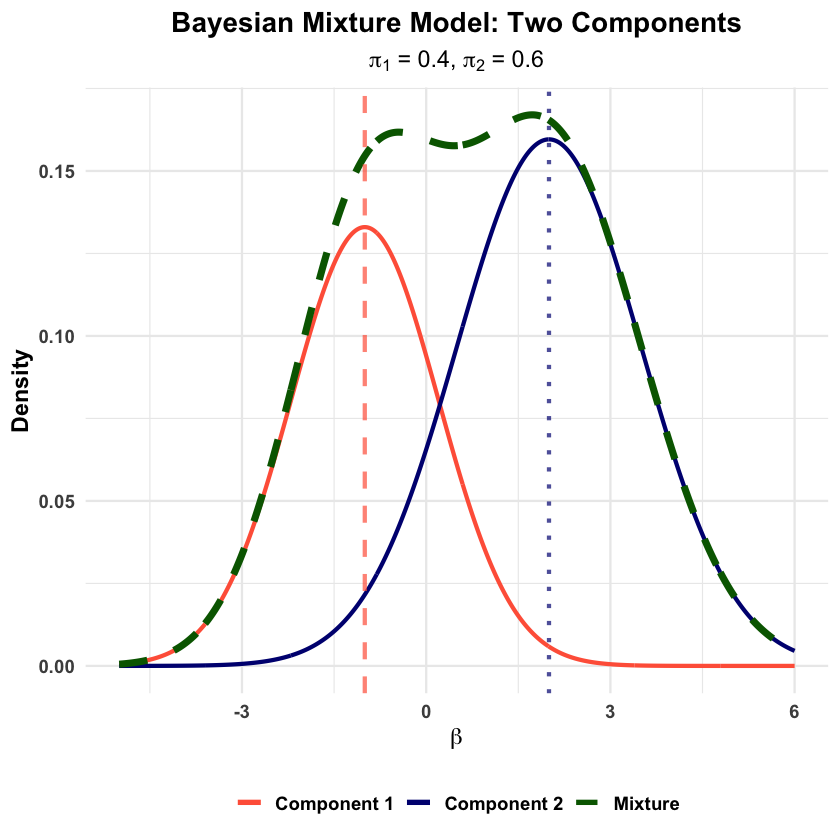

In [ ]:
library(ggplot2)
library(dplyr)

# Set parameters for two components
mu1 <- -1      # Mean of component 1
mu2 <- 2       # Mean of component 2
sigma1 <- 1.2  # SD of component 1
sigma2 <- 1.5  # SD of component 2
pi1 <- 0.4     # Weight of component 1
pi2 <- 0.6     # Weight of component 2

# Create data for plotting
x <- seq(-5, 6, length.out = 1000)

# Individual component densities
component1 <- pi1 * dnorm(x, mu1, sigma1)
component2 <- pi2 * dnorm(x, mu2, sigma2)

# Mixture density
mixture <- component1 + component2

# Create data frame for plotting
plot_data <- data.frame(
  x = rep(x, 3),
  density = c(component1, component2, mixture),
  distribution = rep(c("Component 1", "Component 2", "Mixture"), each = length(x))
)

# Create the plot
p <- ggplot(plot_data, aes(x = x, y = density, color = distribution, linetype = distribution)) +
  geom_line(aes(linewidth = distribution)) +
  scale_linewidth_manual(values = c("Component 1" = 1.2, 
                                   "Component 2" = 1.2, 
                                   "Mixture" = 2.0)) +
  scale_color_manual(values = c("Component 1" = "tomato", 
                               "Component 2" = "#000080", 
                               "Mixture" = "darkgreen")) +
  scale_linetype_manual(values = c("Component 1" = "solid", 
                                  "Component 2" = "solid", 
                                  "Mixture" = "dashed")) +
  labs(
    title = "Bayesian Mixture Model: Two Components",
    subtitle = expression(paste(pi[1], " = 0.4, ", pi[2], " = 0.6")),
    x = expression(beta),
    y = "Density",
    color = "Distribution",
    linetype = "Distribution"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5),
    axis.title.y = element_text(face = "bold"),
    axis.title.x = element_text(face = "bold"),
    axis.text.x = element_text(face = "bold"),
    axis.text.y = element_text(face = "bold"),
    legend.title = element_blank(),
    legend.text = element_text(face = "bold"),
    legend.position = "bottom"
  ) +
  guides(color = guide_legend(override.aes = list(linewidth = 1.5)),
         linewidth = "none")

# Add vertical lines for component means and labels
p <- p + 
  geom_vline(xintercept = mu1, color = "tomato", linetype = "dashed", alpha = 0.7, linewidth = 1.2) +
  geom_vline(xintercept = mu2, color = "#000080", linetype = "dotted", alpha = 0.7, linewidth = 1.2) 

# Display the plot
print(p)

# Save the plot
ggsave("./cartoons/Bayesian_mixture_model.png", plot = p,
       width = 10, height = 6, 
       bg = "transparent",
       dpi = 300)